# Tutorial 1: CommonOcean-io
## Reading, Modifying, and Writing Common Scenarios

This tutorial shows how CommonOcean XML-files can be read, modified, visualized, and stored. To start with, a CommonOcean XML-file consists of a **Scenario** and a **PlanningProblemSet**:
* A **Scenario** represents the environment including a **WatersNetwork** and a set of **DynamicObstacle** and **StaticObstacle**.
    * A **WatersNetwork** is built from waters segments (**Waterways** and **Shallows**), that can be connected.
* A **PlanningProblemSet** contains one **PlanningProblem** for every ego vehicle in the **Scenario**, consisting of an **initial position** and a **GoalRegion** that has to be reached.

## 0. Preparation
* Before you proceed any further, make sure you have skimmed through **CommonOcean API** to gain an overall view of the functionalities provided by CommonOcean modules. You may need to refer to it for implementation details throughout this tutorial.

* Additional documentations on **CommonOcean XML format, Cost Functions, Vessel Models, etc.** can be found at [CommonOcean](https://commonocean.cps.cit.tum.de) on the specific tool pages.

## 1. Read XML file

As documented in the **CommonOcean API**, the **CommonOceanFileReader** reads a CommonOcean XML file, and its **open()** method returns a **Scenario** and a **PlanningProblemSet** object:

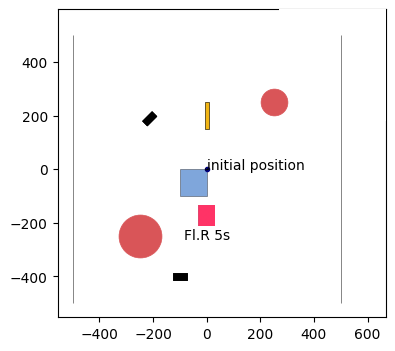

In [12]:
import matplotlib.pyplot as plt
import imageio

# Ignoring warnings for the educational purpose of this tutorial
import warnings
warnings.filterwarnings('ignore')
from commonocean.common.file_reader import CommonOceanFileReader
from commonocean.visualization.draw_dispatch_cr import draw_object

# generate path of the file to be read
file_path = "./CommonOcean_Tutorial01.xml"

# read in the scenario and planning problem set
scenario, planning_problem_set = CommonOceanFileReader(file_path).open()

# plot scenario and planning_problem_set for timeframe 60, for instance
frame = 60
plt.figure(figsize=(9, 4))
draw_object(scenario, draw_params={'time_begin': frame,'trajectory_steps': 0})
draw_object(planning_problem_set, draw_params={'time_begin': frame})
plt.gca().set_aspect('equal')
plt.show()

## 2. Modify XML file

It is possible to modify existing CommonOcean scenarios to customize them to one's need. First, we would like to add a static obstacle to the scenario with the following specification:

    - obstacle type: anchored vessel
    - obstacle shape: rectangle, with a width of 20m and a length of 50m
    - initial state:
        - position: (200, -50) m
        - orientation: 0.5 rad

As documented in **StaticObstacle**, we need to provide the parameters `obstacle_id`,`obstacle_type`, `obstacle_shape` and `initial_state` to construct a static obstacle.

Note! Since every object in the scenario must have a unique ID, we can use the member function **generate_object_id** of **Scenario** class to generate a unique ID for the object.

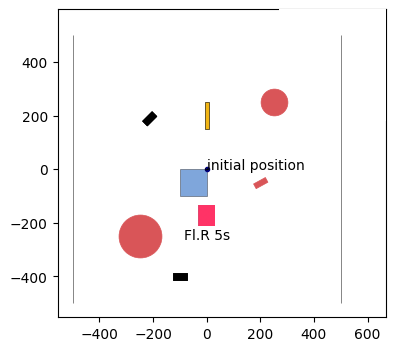

In [13]:
import numpy as np

# import necessary classes from different modules
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.state import CustomState


from commonocean.scenario.obstacle import StaticObstacle, ObstacleType

# read in the scenario and planning problem set
scenario, planning_problem_set = CommonOceanFileReader(file_path).open()

# generate the static obstacle according to the specification, refer to API for details of input parameters
static_obstacle_id = scenario.generate_object_id()
static_obstacle_type = ObstacleType.ANCHOREDVESSEL
static_obstacle_shape = Rectangle(width = 20, length = 50)
static_obstacle_initial_state = CustomState(position = np.array([200, -50]), orientation = 0.5, time_step = 0)

# feed in the required components to construct a static obstacle
static_obstacle = StaticObstacle(
    static_obstacle_id,
    static_obstacle_type,
    static_obstacle_shape,
    static_obstacle_initial_state
)

# add the static obstacle to the scenario
scenario.add_objects(static_obstacle)

# plot scenario and planning_problem_set for timeframe 60
frame = 60
plt.figure(figsize=(9, 4))
draw_object(scenario, draw_params={'time_begin': frame,'trajectory_steps': 0})
draw_object(planning_problem_set, draw_params={'time_begin': frame})
plt.gca().set_aspect('equal')
plt.show()

As can be seen, we have added a new static obstacle to the scenario. We can further add a dynamic obstacle with the following specifications:

    - obstacle type: motorvessel
    - obstacle shape: rectangle with a width of 30m and a length of 60m
    - initial state:
        - position: (400, -400) m
        - orientation: 90°
        - velocity: 15 m/s along y axis
    - we assume that the dynamic obstacle drives with constant velocity.

As documented in **DynamicObstacle**, we need to pass as input a **Prediction** object which in this case is a **TrajectoryPrediction** object. Its generation goes as follows:

    1. compute all subsequent states for the dynamic obstacle
    2. create a Trajectory from these states
    3. create a TrajectoryPrediction from this trajectory and obstacle shape

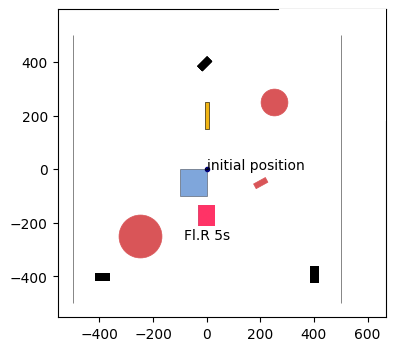

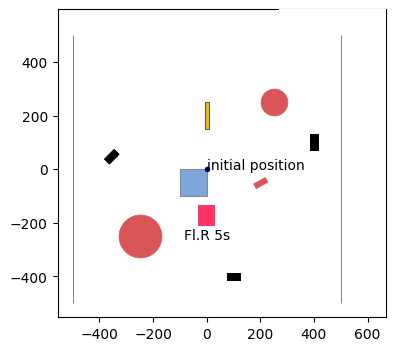

In [9]:
# import necessary classes from different modules
from commonocean.scenario.obstacle import DynamicObstacle
from commonocean.scenario.trajectory import Trajectory
from commonocean.prediction.prediction import TrajectoryPrediction

# initial state has a time step of 0
dynamic_obstacle_initial_state = CustomState(position = np.array([400, -400]),
                                       velocity = 5,
                                       orientation = 3.1416/2,
                                       time_step = 0)

# generate the states for the obstacle for time steps 1 to 100 by assuming constant velocity
state_list = []
for i in range(1, 101):
    # compute new position
    new_position = np.array([400, dynamic_obstacle_initial_state.position[1] + scenario.dt * i * 5])
    # create new state
    new_state = CustomState(position = new_position, velocity = 5 ,orientation = 3.1416/2, time_step = i)
    # add new state to state_list|
    state_list.append(new_state)

# create the trajectory of the obstacle, starting at time step 1
dynamic_obstacle_trajectory = Trajectory(1, state_list)

# create the prediction using the trajectory and the shape of the obstacle
dynamic_obstacle_shape = Rectangle(width = 30, length = 60)
dynamic_obstacle_prediction = TrajectoryPrediction(dynamic_obstacle_trajectory, dynamic_obstacle_shape)

# generate the dynamic obstacle according to the specification
dynamic_obstacle_id = scenario.generate_object_id()
dynamic_obstacle_type = ObstacleType.MOTORVESSEL
dynamic_obstacle = DynamicObstacle(dynamic_obstacle_id, 
                                   dynamic_obstacle_type, 
                                   dynamic_obstacle_shape, 
                                   dynamic_obstacle_initial_state, 
                                   dynamic_obstacle_prediction)

# add dynamic obstacle to the scenario
scenario.add_objects(dynamic_obstacle)

# plot scenario and planning_problem_set for time frame 2 and 100
frame = 2
plt.figure(figsize=(9, 4))
draw_object(scenario, draw_params={'time_begin': frame,'trajectory_steps': 0})
draw_object(planning_problem_set, draw_params={'time_begin': frame})
plt.gca().set_aspect('equal')
plt.show()

frame = 100
plt.figure(figsize=(9, 4))
draw_object(scenario, draw_params={'time_begin': frame,'trajectory_steps': 0})
draw_object(planning_problem_set, draw_params={'time_begin': frame})
plt.gca().set_aspect('equal')
plt.show()

## 3. Write XML file
After we have modified the scenario, we would like to save the changes and write the **Scenario** and **PlanningProblemSet** to a CommonOcean XML file. **CommonOceanFileWriter** helps us with this purpose.
Note that we did not modify the **PlanningProblemSet** in this tutorial.

In [10]:
# import necessary classes from different modules
from commonocean.common.file_writer import CommonOceanFileWriter
from commonocean.common.file_writer import OverwriteExistingFile
from commonocean.scenario.scenario import Location
from commonocean.scenario.scenario import Tag

author = 'John Doe'
affiliation = 'Technical University of Munich, Germany'
source = ''
tags = {Tag.CRITICAL, Tag.HARBOUR}

# write new scenario
fw = CommonOceanFileWriter(scenario, planning_problem_set, author, affiliation, source, tags)

filename = "ZAM_Tutorial-1_1_T-1.xml"
fw.write_to_file(filename, OverwriteExistingFile.ALWAYS)

Replace file ZAM_Tutorial-1_1_T-1.xml


We can open our stored file again to check if everything is correct:

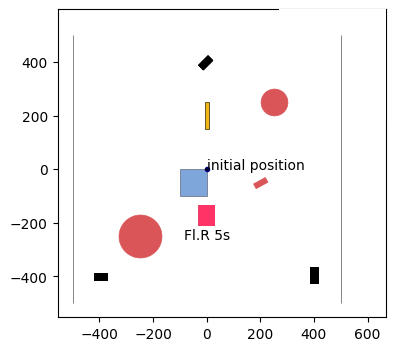

In [11]:
file_path = "ZAM_Tutorial-1_1_T-1.xml"

scenario, planning_problem_set = CommonOceanFileReader(file_path).open()

# plot scenario and planning_problem_set for time frame 1
frame = 1
plt.figure(figsize=(9, 4))
draw_object(scenario, draw_params={'time_begin': frame,'trajectory_steps': 0})
draw_object(planning_problem_set, draw_params={'time_begin': i})
plt.gca().set_aspect('equal')
plt.show()